# SingleNNs Diagnostics

This script runs a number of diagnostics that evaluate the performance of both, SingleNNs & CausalSingleNNs offline (i.e., using test data).

### Setup

In [1]:
import sys
from utils.setup import SetupDiagnostics

# argv  = sys.argv[1:]
argv  = ["-c", "./nn_config/cfg_SingleNNs_Diagnostics.yml"]

setup = SetupDiagnostics(argv)


One can check both, attributes and methods in **setup** by, for example:\
**dir(setup)\
setup.__dict__** # setup.__dict__.keys() & setup.__dict__.values()

### Load Neural Networks

In [2]:
from pathlib import Path
def get_path(setup, model_type, *, pc_alpha=None, threshold=None):
    """ Generate a path based on this model metadata """
    path = Path(setup.nn_output_path, model_type)
    if model_type == "CausalSingleNN":
        path = path / Path(
            "a{pc_alpha}-t{threshold}/".format(
                pc_alpha=pc_alpha, threshold=threshold
            )
        )
    str_hl = str(setup.hidden_layers).replace(", ", "_")
    str_hl = str_hl.replace("[", "").replace("]", "")
    path = path / Path(
        "hl_{hidden_layers}-act_{activation}-e_{epochs}/".format(
            hidden_layers=str_hl,
            activation=setup.activation,
            epochs=setup.epochs,
        )
    )
    return path

In [3]:
from utils.variable import Variable_Lev_Metadata
def get_filename(setup, output):
    """ Generate a filename to save the model """
    i_var   = setup.output_order.index(output.var)
    i_level = output.level_idx
    if i_level is None:
        i_level = 0
    return f"{i_var}_{i_level}"

In [4]:
def get_save_plot_folder(setup, model_type, output, *, pc_alpha=None, threshold=None):
    folder = get_path(setup, model_type, pc_alpha=pc_alpha, threshold=threshold)
    path   = Path(folder, 'diagnostics')
    return path

In [5]:
from tensorflow.keras.models import load_model
def get_model(setup, output, model_type, *, pc_alpha=None, threshold=None):
    """ Get model and input list """
    folder    = get_path(setup, model_type, pc_alpha=pc_alpha, threshold=threshold)
    filename  = get_filename(setup, output)
    
    modelname = Path(folder,filename+'_model.h5')
    print(f"Load model: {modelname}")
    model     = load_model(modelname, compile=False)
    
    inputs_path = Path(folder, f"{filename}_input_list.txt")
    with open(inputs_path) as inputs_file:
        input_indices = [i for i, v in enumerate(inputs_file.readlines()) if int(v)]

    return (model, input_indices)

In [6]:
def get_var_list(setup, target_vars):
    output_list = list()
    for spcam_var in target_vars:
        if spcam_var.dimensions == 3:
            var_levels = [setup.children_idx_levs,setup.parents_idx_levs]\
            [spcam_var.type == 'in']
            for level, _ in var_levels:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                output_list.append(var_name)
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            output_list.append(var_name)
    return output_list

In [7]:
from utils.variable import Variable_Lev_Metadata
import collections
def load_models(setup):
    """ Load all NN models specified in setup """
    models = collections.defaultdict(dict)
    
    output_list = get_var_list(setup, setup.spcam_outputs)
    if setup.do_single_nn:
        for output in output_list:
            output = Variable_Lev_Metadata.parse_var_name(output)
            models['SingleNN'][output] = get_model(
                setup, 
                output, 
                'SingleNN',
                pc_alpha=None,
                threshold=None
            )
    if setup.do_causal_single_nn:
        for pc_alpha in setup.pc_alphas:
            models['CausalSingleNN'][pc_alpha] = {}
            for threshold in setup.thresholds:
                models['CausalSingleNN'][pc_alpha][threshold] = {}
                for output in output_list:
                    output = Variable_Lev_Metadata.parse_var_name(output)
                    models['CausalSingleNN'][pc_alpha][threshold][output] = get_model(
                        setup, 
                        output, 
                        'CausalSingleNN',
                        pc_alpha=pc_alpha, 
                        threshold=threshold
                    )
                    
    return models

In [8]:
models = load_models(setup)

Load model: models_gb_1month/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_relu-e_4/1_0_model.h5
Load model: models_gb_1month/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_relu-e_4/1_1_model.h5
Load model: models_gb_1month/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_relu-e_4/1_2_model.h5
Load model: models_gb_1month/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_relu-e_4/1_3_model.h5
Load model: models_gb_1month/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_relu-e_4/1_4_model.h5
Load model: models_gb_1month/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_relu-e_4/1_5_model.h5
Load model: models_gb_1month/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_relu-e_4/1_6_model.h5
Load model: models_gb_1month/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_relu-e_4/1_7_model.h5
Load model: models_gb_1month/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_relu-e_4/1_8_model.h5
Load model: models_gb_1month/SingleNN/hl_256_256_256_256_256_256_256_256_

### Model Diagnostics

In [74]:
from utils.constants                       import ANCIL_FILE
from utils.variable                        import Variable_Lev_Metadata
from utils.utils import read_ancilaries, find_closest_value, find_closest_longitude, get_weights
from neural_networks.data_generator        import build_valid_generator
from neural_networks.cbrain.utils          import load_pickle
from neural_networks.cbrain.cam_constants  import *
import numpy                               as     np
import numpy.ma                            as     ma
import pandas                              as     pd
import matplotlib.pyplot                   as     plt
from ipykernel.kernelapp                   import IPKernelApp
def in_notebook():
    return IPKernelApp.initialized()
if in_notebook():
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

cThemes = {'tphystnd':'coolwarm',
           'phq':'coolwarm',
           'fsns':'Reds',
           'flns':'Reds',
           'fsnt':'Reds',
           'flnt':'Reds',
           'prect':'PuBu'}


def get_pressure():
    # Get CAM's vertical coordinate in pressure levels
    PS = 1e5; P0 = 1e5;
    P = P0*hyai+PS*hybi; # Total pressure [Pa]
    P = (P[1:] + P[:-1]) / 2 / 100
    return P


class ModelDiagnostics():
    def __init__(self, setup, models, nlat=64, nlon=128, nlev=30, ntime=48):

        self.nlat, self.nlon, self.nlev = nlat, nlon, nlev
        self.ngeo                       = nlat * nlon
        self.setup                      = setup
        self.models                     = models

        self.levels, self.latitudes, self.longitudes = read_ancilaries(
            Path(ANCIL_FILE)
        )
        self.lat_weights = get_weights(self.latitudes)
        
    def reshape_ngeo(self, x, nTime=False):
#        return x.reshape(self.nlat, self.nlon, -1)
        if nTime:
            return x.reshape(nTime, self.nlat, self.nlon)
        else:
            return x.reshape(self.nlat, self.nlon)
    
    def get_output_var_idx(self, var):
        var_idxs = self.valid_gen.norm_ds.var_names[self.valid_gen.output_idxs]
        var_idxs = np.where(var_idxs == var)[0]
        return var_idxs
    

    def get_truth_pred(self, itime, var, nTime=False):
        
        input_list  = get_var_list(self.setup, self.setup.spcam_inputs)
        self.inputs = sorted(
            [Variable_Lev_Metadata.parse_var_name(p) for p in input_list],
            key=lambda x: self.setup.input_order_list.index(x),
        )
        self.input_vars_dict  = ModelDiagnostics._build_vars_dict(self.inputs)
        
        self.output = Variable_Lev_Metadata.parse_var_name(var)
        self.output_vars_dict = ModelDiagnostics._build_vars_dict([self.output])
        
        self.valid_gen       = build_valid_generator(
            self.input_vars_dict, 
            self.output_vars_dict, 
            self.setup,
            test=True
        )
        with self.valid_gen as valid_gen:
            
            model, inputs = self.models[var]
            
            if isinstance(itime, int):
                X, truth = valid_gen[itime]
                pred = model.predict_on_batch(X[:, inputs])
                # Inverse transform
                truth = valid_gen.output_transform.inverse_transform(truth)
                pred = valid_gen.output_transform.inverse_transform(pred)
                
            elif itime == 'mean' or itime == 'range':
                if not nTime:
                    nTime = len(self.valid_gen)
                truth = np.zeros([nTime,self.ngeo,1])
                pred  = np.zeros([nTime,self.ngeo,1])
                for iTime in range(nTime):
                    X_tmp, t_tmp = valid_gen[iTime]
                    p_tmp        = model.predict_on_batch(X_tmp[:, inputs])
                    # Inverse transform
                    truth[iTime,:] = \
                    valid_gen.output_transform.inverse_transform(t_tmp)
                    pred[iTime,:]  = \
                    valid_gen.output_transform.inverse_transform(p_tmp)
                if itime == 'mean':
                    truth = np.mean(truth,axis=0)
                    pred  = np.mean(pred,axis=0)
        
        if itime == 'range':
            truth = self.reshape_ngeo(truth[:, :, 0],nTime=nTime)
            pred  = self.reshape_ngeo(pred[:, :, 0],nTime=nTime)
        else:
            truth = self.reshape_ngeo(truth[:, 0])
            pred  = self.reshape_ngeo(pred[:, 0])

        return truth, pred

    
    def get_pressure(self):
        # Get CAM's vertical coordinate in pressure levels
        PS = 1e5; P0 = 1e5;
        P = P0*hyai+PS*hybi; # Total pressure [Pa]
        P = (P[1:] + P[:-1]) / 2 / 100
        return P
    
    # Plotting functions
    def plot_double_xy(
        self, 
        itime, 
        var,
        nTime=False, 
        save=False, 
        diff=False,
        stats=False,
        **kwargs
    ):
        varname = var.var.value
        
        if stats is not False:
            t, p = self.get_truth_pred('range', var, nTime=nTime)
            psum, tsum, psqsum, tsqsum, sse = self.calc_sums(p,t,nTime)    
            pmean, tmean, bias, mse, pred_mean, true_mean, \
            pred_sqmean, true_sqmean, pred_var, true_var, r2 = \
            self.calc_mean_stats(psum, tsum, psqsum, tsqsum, sse, nTime)
            stats = (stats,locals()[stats])
            t, p = np.mean(t,axis=0), np.mean(p,axis=0)
        else:
            t, p = self.get_truth_pred(itime, var, nTime=nTime)
        
        return self.plot_slices(
            t, 
            p, 
            itime, 
            varname=varname, 
            save=save, 
            diff=diff,
            stats=[False,stats][stats is not False],
            **kwargs 
        )


    def plot_double_yz(
        self, 
        var,
        varkeys,
        itime=1,  
        nTime=False,
        ilon=1,
        save=False, 
        diff=False,
        stats=False,
        **kwargs
    ):  
        varname = var.var.value  
        # Allocate array
        truth      = np.zeros([self.nlev, self.nlat])
        pred       = np.zeros([self.nlev, self.nlat])
        mean_stats = np.zeros([self.nlev, self.nlat])
        for var in varkeys:
            iLev = ModelDiagnostics._build_vars_dict([var])[var.var.value.upper()][0]

            if stats is not False:
                t, p = self.get_truth_pred('range', var, nTime=nTime)
                psum, tsum, psqsum, tsqsum, sse = self.calc_sums(p,t,nTime)    
                pmean, tmean, bias, mse, pred_mean, true_mean, \
                pred_sqmean, true_sqmean, pred_var, true_var, r2_tmp = \
                self.calc_mean_stats(psum, tsum, psqsum, tsqsum, sse, nTime)
                t, p = np.mean(t,axis=0), np.mean(p,axis=0)
            else:
                t, p = self.get_truth_pred(itime, var, nTime=nTime)
            
            if isinstance(ilon, int):
                truth[iLev,:] = t[:,ilon]
                pred[iLev,:]  = p[:,ilon]
                if stats is not False:
                    hor_tsqmean   = true_sqmean[:,ilon]
                    hor_tmean     = true_mean[:,ilon]
                    hor_mse       = mse[:,ilon]
            elif ilon == 'mean':
                truth[iLev,:] = np.mean(t, axis=1)
                pred[iLev,:]  = np.mean(p, axis=1)
                if stats is not False:
                    hor_tsqmean   = np.mean(true_sqmean,axis=1)
                    hor_tmean     = np.mean(true_mean,axis=1)
                    hor_mse       = np.mean(mse,axis=1)
            if stats is not False:
                hor_tvar = hor_tsqmean - hor_tmean ** 2
                hor_r2   = 1 - (hor_mse / hor_tvar)
                mean_stats[iLev,:] = locals()['hor_'+stats]
                
        return self.plot_slices(
            truth, 
            pred, 
            itime, 
            varname=varname, 
            stype='yz',
            save=save, 
            diff=diff,
            stats=[False,(stats,mean_stats)][stats is not False],
            **kwargs
        )
    
    
    def plot_slices(
        self, 
        t, 
        p, 
        itime, 
        title='', 
        unit='', 
        varname='', 
        stype=False,
        save=False,
        diff=False,
        stats=False,
        **kwargs
    ):
        n_slices  = [3,2][diff is False]
        n_slices  = [n_slices+1,n_slices][stats is False]
        fig, axes = plt.subplots(1, n_slices, figsize=(12, 5))
        
        vmin = np.min([np.min(p),np.min(t)])
        vmax = np.max([np.max(p),np.max(t)])
        if varname in ['tphystnd','phq']:
            vlim = np.max([np.abs(vmin),np.abs(vmax)])/2.
            vmin = -vlim; vmax = vlim
        elif varname in ['fsns','fsnt','prect']:
            vmin = 0

        cmap = cThemes[varname]
        cmap_diff = 'coolwarm'
        
        vars_to_plot = [np.array([p, t]),np.array([p, t, p-t])][diff is True]
        labs_to_plot = [['Prediction', 'SPCAM', 'Prediction - SPCAM'],
                        ['Prediction', 'SPCAM']][diff is False]
        if stats is not False:
            vars_to_plot = np.insert(vars_to_plot, len(vars_to_plot), stats[1], axis=0)
            labs_to_plot.append(stats[0])
        for iSlice in range(n_slices):
            var_to_plot = vars_to_plot[iSlice]
            lab_to_plot = labs_to_plot[iSlice]
            if lab_to_plot == 'Prediction - SPCAM':
                lmin=-vmax/2.; lmax=vmax/2.
                cmap_theme=cmap_diff
            elif lab_to_plot == 'r2':
                lmin=-1; lmax=1
                cmap_theme='coolwarm'
            elif lab_to_plot == 'mse':
                lmin=0; lmax=np.max(stats[1])
                cmap_theme='Reds'
            else:
                lmin=vmin; lmax=vmax
                cmap_theme=cmap
            I  = axes[iSlice].imshow(
                var_to_plot, 
                vmin=lmin,
                vmax=lmax,
                cmap=cmap_theme,
                **kwargs
            )
            cb = fig.colorbar(I, ax=axes[iSlice], orientation='horizontal')
            cb.set_label(unit)
            axes[iSlice].set_title(lab_to_plot)
            if stype == 'yz':
                P       = self.get_pressure()
                P_ticks = [int(press) for press in range(len(P)) if press %5 ==0]
                P_label = [str(int(press)) for i, press in enumerate(P) if i %5 == 0]
                axes[iSlice].set_yticks(P_ticks)
                axes[iSlice].set_yticklabels(P_label)
                axes[iSlice].set_ylabel('hPa')
                lat_ticks  = [int(l) for l in range(len(self.latitudes)) if l %9 ==0]
                lat_labels = [str(int(l)) for i, l in enumerate(self.latitudes) if i %9 == 0]
                axes[iSlice].set_xticks(lat_ticks)
                axes[iSlice].set_xticklabels(lat_labels)
                axes[iSlice].set_xlabel('Latitude')
        
        fig.suptitle(title)
        if save:
            Path(save).mkdir(parents=True, exist_ok=True)
            fig.savefig(f"{save}/{var}_map_time-{itime}.png")
        return fig, axes


    def get_profiles(
        self,
        var,
        varkeys,
        itime=1, 
        nTime=False,
        lats=[-90,90],
        lons=[0.,359.],
        stats=False,
        **kwargs
    ):  
        varname = var.var.value

        if not nTime and isinstance(itime, int): nTime = 1
        else: 
            t, p = self.get_truth_pred(itime, varkeys[0], nTime=nTime)
            nTime = len(t)

        idx_lats = [find_closest_value(self.latitudes, lat) for lat in lats]
        idx_lons = [find_closest_longitude(self.longitudes, lon) for lon in lons]

        # Allocate array
        truth = np.zeros([nTime, self.nlev])
        pred  = np.zeros([nTime, self.nlev])
        mean_stats = np.zeros([self.nlev])
        for var in varkeys:
            iLev = ModelDiagnostics._build_vars_dict([var])[var.var.value.upper()][0]
            t, p = self.get_truth_pred(itime, var, nTime=nTime)
            
            truth[:, iLev] = np.average(
                np.mean(t[idx_lats[0]:idx_lats[-1]+1, idx_lons[0]:idx_lons[-1]+1],axis=2),
                weights=self.lat_weights[idx_lats[0]:idx_lats[-1]+1],axis=1
            )
            pred[:, iLev] = np.average(
                np.mean(p[idx_lats[0]:idx_lats[-1]+1, idx_lons[0]:idx_lons[-1]+1],axis=2),
                weights=self.lat_weights[idx_lats[0]:idx_lats[-1]+1],axis=1
            )
            
            if stats is not False:
                psum, tsum, psqsum, tsqsum, sse = self.calc_sums(p,t,nTime)    
                pmean, tmean, bias, mse, pred_mean, true_mean, \
                pred_sqmean, true_sqmean, pred_var, true_var, r2_tmp = \
                self.calc_mean_stats(psum, tsum, psqsum, tsqsum, sse, nTime)
                hor_tsqmean = np.average(
                    np.mean(true_sqmean[idx_lats[0]:idx_lats[-1]+1, idx_lons[0]:idx_lons[-1]+1],axis=1),
                    weights=self.lat_weights[idx_lats[0]:idx_lats[-1]+1]
                )
                hor_tmean   = np.average(
                    np.mean(true_mean[idx_lats[0]:idx_lats[-1]+1, idx_lons[0]:idx_lons[-1]+1],axis=1),
                    weights=self.lat_weights[idx_lats[0]:idx_lats[-1]+1]
                )
                hor_mse     = np.average(
                    np.mean(mse[idx_lats[0]:idx_lats[-1]+1, idx_lons[0]:idx_lons[-1]+1],axis=1),
                    weights=self.lat_weights[idx_lats[0]:idx_lats[-1]+1])
                hor_tvar = hor_tsqmean - hor_tmean ** 2
                hor_r2   = 1 - (hor_mse / hor_tvar)
                mean_stats[iLev] = locals()['hor_'+stats]
                
        return truth, pred, mean_stats

    
    def plot_double_profile(
        self,
        var,
        varkeys,
        itime=1, 
        nTime=False,
        lats=[-90,90],
        lons=[0.,359.],
        save=False, 
        stats=False,
        **kwargs
    ):  
        varname = var.var.value

        if not nTime and isinstance(itime, int): nTime = 1
        else: 
            t, p = self.get_truth_pred(itime, varkeys[0], nTime=nTime)
            nTime = len(t)

        idx_lats = [find_closest_value(self.latitudes, lat) for lat in lats]
        idx_lons = [find_closest_longitude(self.longitudes, lon) for lon in lons]

        # Allocate array
        truth      = np.zeros([nTime, self.nlev])
        pred       = np.zeros([nTime, self.nlev])
        mean_stats = np.zeros([self.nlev])
        for var in varkeys:
            iLev = ModelDiagnostics._build_vars_dict([var])[var.var.value.upper()][0]
            t, p = self.get_truth_pred(itime, var, nTime=nTime)
            
            truth[:, iLev] = np.average(
                np.mean(t[idx_lats[0]:idx_lats[-1]+1, idx_lons[0]:idx_lons[-1]+1],axis=2),
                weights=self.lat_weights[idx_lats[0]:idx_lats[-1]+1],axis=1
            )
            pred[:, iLev] = np.average(
                np.mean(p[idx_lats[0]:idx_lats[-1]+1, idx_lons[0]:idx_lons[-1]+1],axis=2),
                weights=self.lat_weights[idx_lats[0]:idx_lats[-1]+1],axis=1
            )
            
            if stats is not False:
                psum, tsum, psqsum, tsqsum, sse = self.calc_sums(p,t,nTime)    
                pmean, tmean, bias, mse, pred_mean, true_mean, \
                pred_sqmean, true_sqmean, pred_var, true_var, r2_tmp = \
                self.calc_mean_stats(psum, tsum, psqsum, tsqsum, sse, nTime)
                hor_tsqmean = np.average(
                    np.mean(true_sqmean[idx_lats[0]:idx_lats[-1]+1, idx_lons[0]:idx_lons[-1]+1],axis=1),
                    weights=self.lat_weights[idx_lats[0]:idx_lats[-1]+1]
                )
                hor_tmean   = np.average(
                    np.mean(true_mean[idx_lats[0]:idx_lats[-1]+1, idx_lons[0]:idx_lons[-1]+1],axis=1),
                    weights=self.lat_weights[idx_lats[0]:idx_lats[-1]+1]
                )
                hor_mse     = np.average(
                    np.mean(mse[idx_lats[0]:idx_lats[-1]+1, idx_lons[0]:idx_lons[-1]+1],axis=1),
                    weights=self.lat_weights[idx_lats[0]:idx_lats[-1]+1])
                hor_tvar = hor_tsqmean - hor_tmean ** 2
                hor_r2   = 1 - (hor_mse / hor_tvar)
                mean_stats[iLev] = locals()['hor_'+stats]
        
        return self.plot_profiles(
            truth, 
            pred, 
            itime, 
            varname=varname,
            nTime=False,
            lats=[-90,90],
            lons=[0.,359.],
            save=False, 
            stats=[False,(stats,mean_stats)][stats is not False], 
            **kwargs
        )
    

    def plot_profiles(
        self, 
        t, 
        p, 
        itime, 
        title='', 
        unit='', 
        varname='',
        nTime=False,
        lats=[-90,90],
        lons=[0.,359.],
        save=False, 
        stats=False,
        **kwargs
    ):
        
        P    = self.get_pressure()
        
        n_cols = [1,2][stats is not False]
        fig = plt.figure(1, figsize=(12, 5))
        ax1  = plt.subplot(1, n_cols, 1)
        
        vmin = np.min([np.min(p),np.min(t)])
        vmax = np.max([np.max(p),np.max(t)])
        vlim = np.max([np.abs(vmin),np.abs(vmax)])/2.
        vmin = -vlim; vmax = vlim
        
        vars_to_plot = [p, t]
        labs_to_plot = ['Prediction', 'SPCAM']
        if stats is not False:
            labs_to_plot.append(stats[0])
        colors       = ['b','b','k']
        linestyles   = ['--','-','-']
        for iVar in range(len(vars_to_plot)):
            var_to_plot = vars_to_plot[iVar]
            lab_to_plot = labs_to_plot[iVar]
            ax1.plot(
                np.mean(var_to_plot,axis=0),
                P,
                label=lab_to_plot,
                color=colors[iVar],
                linestyle=linestyles[iVar],
                alpha=.8,
                **kwargs
            )
        ax1.invert_yaxis()
        ax1.set_xlim(vmin, vmax)
        ax1.set_xlabel(f" ({unit})")
        ax1.set_ylabel('Pressure (hPa)')
        ax1.legend(loc=0)
        
        if stats is not False:
            ax2  = plt.subplot(1, n_cols, 2)
            ax2.plot(
                stats[1],
                P,
                'k-',
                label=varname,
                alpha=.8,
                **kwargs
            )
            ax2.invert_yaxis()
            ax2.set_xlabel(stats[0])
            ax2.set_ylabel('Pressure (hPa)')
            ax2.legend(loc=0)
    
        fig.suptitle(title)
        if save:
            Path(save).mkdir(parents=True, exist_ok=True)
            fig.savefig(f"{save}/{var}_profile_time-{itime}.png")
        return fig
    

    def calc_sums(self, p, t, nTime):
        # Allocate stats arrays
        psum = np.zeros((self.nlat, self.nlon))
        tsum = np.copy(psum)
        sse = np.copy(psum)
        psqsum = np.copy(psum)
        tsqsum = np.copy(psum)
#        for it in tqdm(range(nTime)):
        for it in range(nTime):
            # Compute statistics
            psum += p[it]
            tsum += t[it]
            psqsum += p[it] ** 2
            tsqsum += t[it] ** 2
            sse += (t[it] - p[it]) ** 2
        return psum, tsum, psqsum, tsqsum, sse    
    
    
    def calc_mean_stats(self, psum, tsum, psqsum, tsqsum, sse, nTime):
        pmean       = psum / nTime
        tmean       = tsum / nTime
        bias        = pmean - tmean
        mse         = sse / nTime
        pred_mean   = psum / nTime
        true_mean   = tsum / nTime
        pred_sqmean = psqsum / nTime
        true_sqmean = tsqsum / nTime
        pred_var    = psqsum / nTime - pmean ** 2
        true_var    = tsqsum / nTime - tmean ** 2
        r2          = 1. - (mse / true_var)
        r2          = ma.masked_invalid(r2)
        return pmean, tmean, bias, mse, pred_mean, true_mean, \
               pred_sqmean, true_sqmean, pred_var, true_var, r2
    
    
    # Statistics computation
    def compute_stats(self, itime, var, nTime=False):
        """Compute statistics in for [lat, lon, var, lev]"""
        
        t, p = self.get_truth_pred(itime, var, nTime=nTime)
        
        psum, tsum, psqsum, tsqsum, sse = self.calc_sums(p,t,nTime)
            
        # Compute average statistics
        pmean, tmean, bias, mse, pred_mean, true_mean, \
        pred_sqmean, true_sqmean, pred_var, true_var, r2 = \
        self.calc_mean_stats(psum, tsum, psqsum, tsqsum, sse, nTime)
        
        # Compute horizontal stats: single value per var
        self.stats                = {}
        self.stats['hor_tsqmean'] = np.average(np.mean(true_sqmean,axis=1),weights=self.lat_weights)
        self.stats['hor_tmean']   = np.average(np.mean(true_mean,axis=1),weights=self.lat_weights)
        self.stats['hor_mse']     = np.average(np.mean(mse,axis=1),weights=self.lat_weights)
        self.stats['hor_tvar']    = self.stats['hor_tsqmean'] - self.stats['hor_tmean'] ** 2
        self.stats['hor_r2']      = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])
    
    
    def mean_stats(self):
        """Get average statistics for each variable and returns dataframe"""
        df = pd.DataFrame(index=self.valid_gen.output_vars,
                          columns=list(self.stats.keys()))
        for ivar, var in enumerate(self.valid_gen.output_vars):
            for stat_name, stat in self.stats.items():
                # Stats have shape [lat, lon]
                if 'hor_' in stat_name:
                    df.loc[var, stat_name] = stat
                else:
                    df.loc[var, stat_name] = ma.mean(stat[..., self.get_output_var_idx(var)])
        self.stats_df = df
        return df
    
    
    @staticmethod
    def _build_vars_dict(list_variables):
        """ Convert the given list of Variable_Lev_Metadata into a
        dictionary to be used on the data generator.
        
        Parameters
        ----------
        list_variables : list(Variable_Lev_Metadata)
            List of variables to be converted to the dictionary format
            used by the data generator
        
        Returns
        -------
        vars_dict : dict{str : list(int)}
            Dictionary of the form {ds_name : list of levels}, where
            "ds_name" is the name of the variable as stored in the
            dataset, and "list of levels" a list containing the indices
            of the levels of that variable to use, or None for 2D
            variables.
        """
        vars_dict = dict()
        for variable in list_variables:
            ds_name = variable.var.ds_name  # Name used in the dataset
            if variable.var.dimensions == 2:
                vars_dict[ds_name] = None
            elif variable.var.dimensions == 3:
                levels = vars_dict.get(ds_name, list())
                levels.append(variable.level_idx)
                vars_dict[ds_name] = levels
        return vars_dict

### Map plots

In [ ]:
model_type = 'SingleNN'
md = ModelDiagnostics(setup = setup, models=models[model_type])
for var in models[model_type].keys():
    print(var)
    outPath = get_save_plot_folder(setup, model_type, var)
    md.plot_double_xy('mean', var, nTime=5, diff=True, stats='r2')#, save=outPath)
    md.plot_double_xy('mean', var, nTime=5, diff=True, stats='mse')#, save=outPath)
#     md.plot_double_xy('mean', var, nTime=5, diff=True)#, save=outPath)
#    md.plot_double_xy(100, var, nTime=False, diff=True)#, save=outPath)
    plt.show()
    break

In [ ]:
model_type = 'CausalSingleNN'
for pc_alpha in models[model_type].keys():
    print(f"pc_alpha: {pc_alpha}")
    for threshold in models[model_type][pc_alpha].keys():
        print(f"threshold: {threshold}")
        md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])
        for var in models[model_type][pc_alpha][threshold].keys():
            print(f"variable: {var}\n")
            md.plot_double_xy('mean', var, nTime=5, diff=True, stats='r2')#, save=outPath)
            md.plot_double_xy('mean', var, nTime=5, diff=True, stats='mse')#, save=outPath)
#             md.plot_double_xy('mean', var, nTime=5, diff=True)#, save=outPath)
#             md.plot_double_xy(100, var, nTime=False, diff=True)#, save=outPath)
            plt.show()

### Cross-section plots

tphystnd


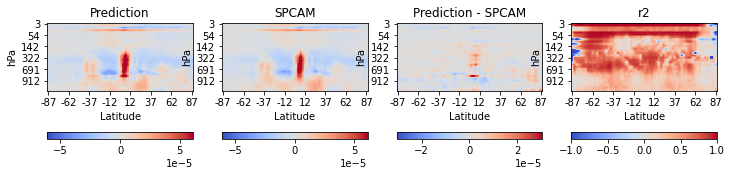

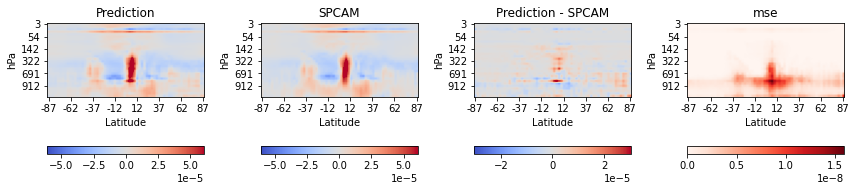

In [60]:
model_type = 'SingleNN'
md = ModelDiagnostics(setup = setup, models=models[model_type])
vars_to_ploted = []
for var in models[model_type].keys():
    if var.var.value not in vars_to_ploted and var.var.dimensions == 3:
        print(var.var.value)
        outPath = get_save_plot_folder(setup, model_type, var.var.value)
        var_keys = [v for v in models[model_type].keys() if var.var.value in str(v)]
#        md.plot_double_yz(var,var_keys,itime=100,nTime=False,ilon=100,diff=True)
        md.plot_double_yz(var,var_keys,itime='mean',nTime=10,ilon='mean',diff=True,stats='r2')
        md.plot_double_yz(var,var_keys,itime='mean',nTime=10,ilon='mean',diff=True,stats='mse')
        vars_to_ploted.append(var.var.value)
        plt.tight_layout()
        plt.show()

pc_alpha: 0.001
threshold: 0.15
tphystnd


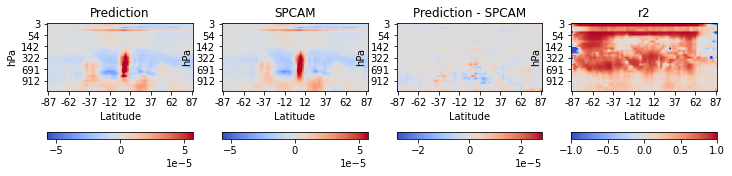

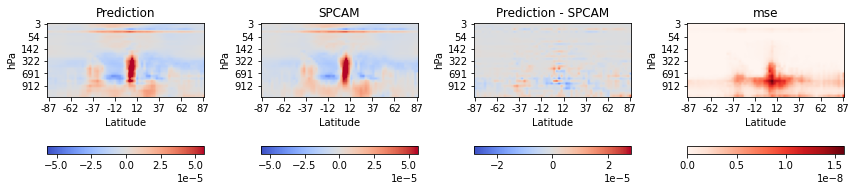

In [61]:
model_type = 'CausalSingleNN'
vars_to_ploted = []
for pc_alpha in models[model_type].keys():
    print(f"pc_alpha: {pc_alpha}")
    for threshold in models[model_type][pc_alpha].keys():
        print(f"threshold: {threshold}")
        md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])
        for var in models[model_type][pc_alpha][threshold].keys():
            if var.var.value not in vars_to_ploted and var.var.dimensions == 3:
                print(var.var.value)
                outPath = get_save_plot_folder(setup, model_type, var.var.value)
                var_keys = [v for v in models[model_type][pc_alpha][threshold].keys() \
                            if var.var.value in str(v)]
#                 md.plot_double_yz(var,var_keys,itime=100,nTime=False,ilon=100,diff=True)
                md.plot_double_yz(var,var_keys,itime='mean',nTime=10,ilon='mean',diff=True,stats='r2')
                md.plot_double_yz(var,var_keys,itime='mean',nTime=10,ilon='mean',diff=True,stats='mse')
                vars_to_ploted.append(var.var.value)
                plt.tight_layout()
                plt.show()

### Profile plots

In [69]:
def plot_profiles(
    vars_dict,
    varname='',
    title='', 
    unit='',
    save=False, 
    stats=False,
    **kwargs
):

    P = get_pressure()

    n_cols = [1,2][stats is not False]
    fig    = plt.figure(1, figsize=(12, 5))
    ax1    = plt.subplot(1, n_cols, 1)
    if stats is not False:
        ax2  = plt.subplot(1, n_cols, 2)

    truth = False
    for i, iMod in enumerate(vars_dict.keys()):
        if not truth:
            ax1.plot(
                np.mean(vars_dict[iMod][varname]['t'],axis=0),
                P,
                color='k',
                label='SPCAM',
                alpha=.8,
                **kwargs
            )
            truth = True
        ax1.plot(
            np.mean(vars_dict[iMod][varname]['p'],axis=0),
            P,
            label=vars_dict[iMod][varname]['lab'],
            alpha=.8,
            **kwargs
        )
        if stats is not False:
            ax2.plot(
                vars_dict[iMod][varname][stats][1],
                P,
                label=vars_dict[iMod][varname]['lab'],
                alpha=.8,
                **kwargs
            )
    
    ax1.invert_yaxis()
#    ax1.set_xlim(vmin, vmax)
    ax1.set_xlabel(f" {varname} ({unit})")
    ax1.set_ylabel('Pressure (hPa)')
    ax1.legend(loc=0)
    
    if stats is not False:
        ax2.invert_yaxis()
        if stats == 'r2':
            ax2.set_xlim(0., 1.)
        elif stats == 'mse':
            ax2.set_xlim(0., np.max(vars_dict[iMod][varname][stats][1]))
        ax2.set_xlabel(vars_dict[iMod][varname][stats][0])
        ax2.set_ylabel('Pressure (hPa)')
        ax2.legend(loc=0)
    
    fig.suptitle(title)
    if save is not False:
        Path(save).mkdir(parents=True, exist_ok=True)
        fig.savefig(f"{save}/{varname}_profile.png")
    plt.show()

Model: SingleNN; variable: tphystnd

Model: CausalSingleNN_0.001_0.15; variable: tphystnd



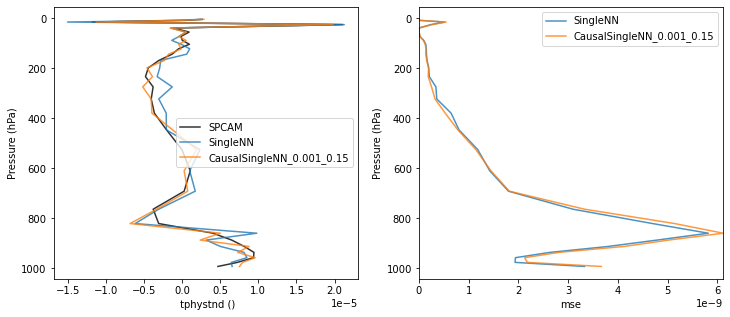

In [71]:
models_type = [setup.nn_type,["SingleNN","CausalSingleNN"]][setup.nn_type=='all']
vars_dict = {}
statsnm   = 'mse' # 'r2'; 'mse'
# Get profiles
for iMod, model_type in enumerate(models_type):
    if model_type == 'SingleNN':
        md = ModelDiagnostics(setup = setup, models=models[model_type])
        vars_dict[model_type] = {}
        for var in models[model_type].keys():
            if var.var.value not in vars_dict[model_type] and var.var.dimensions == 3:
                print(f'Model: {model_type}; variable: {var.var.value}\n')
                var_keys = [v for v in models[model_type].keys() if var.var.value in str(v)]
                truth, pred, stats = md.get_profiles(var, var_keys, itime='range', nTime=5, stats=statsnm)
                vars_dict[model_type][var.var.value] = {
                    'p':pred, 
                    't':truth, 
                    statsnm:(statsnm,stats), 
                    'lab':model_type
                }
    elif model_type == 'CausalSingleNN':
        for pc_alpha in models[model_type].keys():
            for threshold in models[model_type][pc_alpha].keys():
                c_model_type = f'{model_type}_{pc_alpha}_{threshold}'
                vars_dict[c_model_type] = {}
                md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])
                for var in models[model_type][pc_alpha][threshold].keys():
                    if var.var.value not in vars_dict[c_model_type] and var.var.dimensions == 3:
                        print(f'Model: {c_model_type}; variable: {var.var.value}\n')
                        var_keys = [v for v in models[model_type][pc_alpha][threshold].keys() \
                                    if var.var.value in str(v)]
                        truth, pred, stats = md.get_profiles(
                            var, var_keys, itime='range', nTime=5, stats=statsnm
                        )
                        vars_dict[f'{c_model_type}'][var.var.value] = {
                            'p':pred, 
                            't':truth, 
                            statsnm:(statsnm,stats),
                            'lab':c_model_type,
                        }

# Plot profile
plot_profiles(
    vars_dict,
    varname='tphystnd',
    title='',
    unit='',
    save=False,
#     save='.',
    stats=statsnm
)

### Profile plots (within ModelDiagnostics)

tphystnd


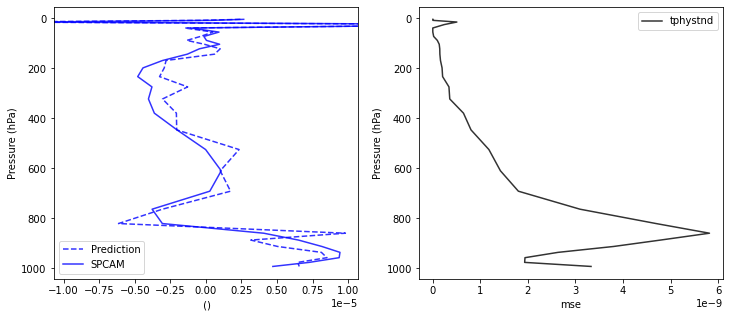

In [80]:
model_type = 'SingleNN'
md = ModelDiagnostics(setup = setup, models=models[model_type])
vars_to_plot = []
for var in models[model_type].keys():
    if var.var.value not in vars_to_plot and var.var.dimensions == 3:
        print(var.var.value)
        outPath = get_save_plot_folder(setup, model_type, var.var.value)
        var_keys = [v for v in models[model_type].keys() if var.var.value in str(v)]
#         md.plot_double_profile(var,var_keys,itime='range',nTime=5,stats='r2')#,save=outPath)
        md.plot_double_profile(var,var_keys,itime='range',nTime=5,stats='mse')#,save=outPath)
        vars_to_plot.append(var.var.value)
        plt.show()

pc_alpha: 0.001
threshold: 0.15
tphystnd


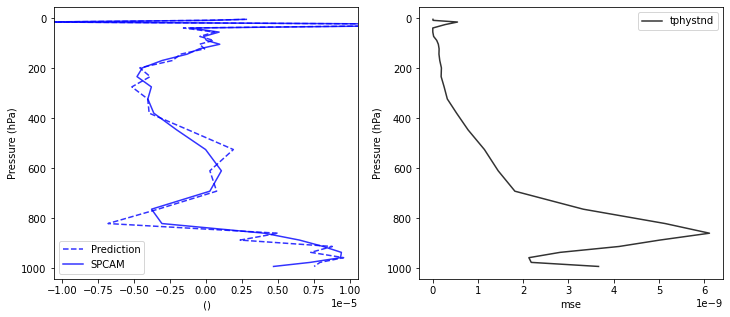

In [79]:
model_type = 'CausalSingleNN'
vars_to_plot = []
for pc_alpha in models[model_type].keys():
    print(f"pc_alpha: {pc_alpha}")
    for threshold in models[model_type][pc_alpha].keys():
        print(f"threshold: {threshold}")
        md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])
        for var in models[model_type][pc_alpha][threshold].keys():
            if var.var.value not in vars_to_plot and var.var.dimensions == 3:
                print(var.var.value)
                outPath = get_save_plot_folder(setup, model_type, var.var.value)
                var_keys = [v for v in models[model_type][pc_alpha][threshold].keys() \
                            if var.var.value in str(v)]
#                 md.plot_double_profile(var,var_keys,itime='range',nTime=5,stats='r2')#,save=outPath)
                md.plot_double_profile(var,var_keys,itime='range',nTime=5,stats='mse')#,save=outPath)
                vars_to_plot.append(var.var.value)
                plt.show()

### Statistics

In [ ]:
model_type = 'SingleNN'
md = ModelDiagnostics(setup = setup, models=models[model_type])
for var in models[model_type].keys():
    print(f"variable: {var}\n")
    md.compute_stats('range', var, nTime=5)
    stats = md.mean_stats()
    print(stats)

In [ ]:
model_type = 'CausalSingleNN'
for pc_alpha in models[model_type].keys():
    print(f"pc_alpha: {pc_alpha}")
    for threshold in models[model_type][pc_alpha].keys():
        print(f"threshold: {threshold}")
        md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])
        for var in models[model_type][pc_alpha][threshold].keys():
            print(f"variable: {var}\n")
            md.compute_stats('range', var, nTime=100)
            stats = md.mean_stats()
            print(stats)